In [316]:
import pytse_client as tse
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
# tickers = tse.download(symbols="all", write_to_csv=True)

Device = ("cuda"
          if torch.cuda.is_available()
          else "cpu"
)
print(f"Using {Device} device")
days_history=100
days_predict=30

Using cuda device


In [322]:
class Model(nn.Module):
    def __init__(self,input_size,output_size):
        n=128
        super().__init__()
        self.Lin1 = nn.Linear(input_size,2*n)
        self.Lin2 = nn.Linear(2*n,4*n)
        self.Lin3 = nn.Linear(4*n,2*n)
        self.Lin4 = nn.Linear(2*n,n)
        self.Lin5 = nn.Linear(n,output_size)
        self.activation1 = nn.LeakyReLU(negative_slope=0.01)
        self.activation2 = nn.Tanh()
        self.drop = nn.Dropout(p=0.8)
        self.norm = nn.BatchNorm1d(4*n)
    def forward(self, x):
        x = self.Lin1(x)
        x = self.activation1(x)
        x = self.drop(x) ###
        x = self.Lin2(x)
        x = self.norm(x) ####
        x = self.activation1(x)
        x = self.drop(x) ###
        x = self.Lin3(x)
        x = self.activation1(x)
        x = self.drop(x) ###

        x = self.Lin4(x)
        x = self.activation1(x) 
        x = self.drop(x) ###
        x = self.Lin5(x)

        return x

model=Model(days_history*5,days_predict).to(device=Device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
LossFn = nn.HuberLoss()
gama=0.99
W_gama=torch.diag(torch.tensor([gama**(1*i) for i in range(days_predict)],device=Device))
#for p in model.parameters():
#    p.data.fill_(0)

In [318]:
names = ["آباد","آبادا","آپ","اپرداز","آساس","افرا","اهرم","انرژی","بترانس","بنیرو","پترول","وبملت"]
#names = [names[11]]

stock_num = len(names)
stocks = []
for ii in range(stock_num):
    sym = names[ii]
    ticker=tse.Ticker(sym)
    length=ticker.history.shape[0]
    train_length = int(np.floor(length*0.70))
    test_length = length - train_length

    # Now we extract some portion of the first sequences of data for train
    X_train=np.zeros([train_length - days_history - days_predict , days_history,5])
    Y_train=np.zeros([train_length - days_history - days_predict , days_predict])
    for i in range(train_length - days_history - days_predict):
        m = ticker.history.loc[i : i + days_history - 1].to_numpy()
        first_day_price = m[0,9]
        X_train[i,:,:] = np.array([m[:,9]/first_day_price , m[:,7]/1e3 , m[:,6]/1e6 , m[:,2]/first_day_price , m[:,3]/first_day_price]).T
        m = ticker.history.loc[i + days_history : i + days_history - 1 + days_predict].to_numpy()
        Y_train[i,:] = m[:,9]/first_day_price

    # Now we extract some portion of the last sequences of data for test
    X_test=np.zeros([test_length - days_predict , days_history, 5])
    Y_test=np.zeros([test_length - days_predict , days_predict])
    for i in range(test_length - days_predict):
        j = i + train_length - days_history
        m = ticker.history.loc[j : j + days_history - 1].to_numpy()
        first_day_price = m[0,9]
        X_test[i,:,:] = np.array([m[:,9]/first_day_price , m[:,7]/1e3 , m[:,6]/1e6 , m[:,2]/first_day_price , m[:,3]/first_day_price]).T
        m = ticker.history.loc[j + days_history : j + days_history - 1 + days_predict].to_numpy()
        Y_test[i,:] = m[:,9]/first_day_price

    train_arr = np.arange(train_length - days_history - days_predict - 1)
    train_idx = np.random.permutation(train_arr)
    X_train = X_train[train_idx]
    Y_train = Y_train[train_idx]

    test_arr = np.arange(test_length - days_predict - 1)
    test_idx = np.random.permutation(test_arr)
    X_test = X_test[test_idx]
    Y_test = Y_test[test_idx]
    
    X_train = torch.from_numpy(X_train).to(device=Device,dtype=torch.float32)
    Y_train = torch.from_numpy(Y_train).to(device=Device,dtype=torch.float32)

    X_test = torch.from_numpy(X_test).to(device=Device,dtype=torch.float32)
    Y_test = torch.from_numpy(Y_test).to(device=Device,dtype=torch.float32)

    stocks.append([X_test,Y_test,X_train,Y_train])

In [323]:
train_Losses=[]
test_Losses=[]
batch_size = 64
for epoch in range(10):
    model.train()
    train_loss=torch.tensor(0,dtype=torch.float32)
    N_total_train = 0
    loss_sum = 0
    for ii in range(stock_num):
        [_,_,X_train,Y_train] = stocks[ii]
        N_train = int(np.floor(X_train.size(0)/batch_size))
        N_total_train += N_train
        for i in range(N_train):
            x = torch.flatten(X_train[i*batch_size:(i+1)*batch_size,:,:],start_dim=1)
            y = Y_train[i*batch_size:(i+1)*batch_size,:]
            optimizer.zero_grad()
            output = model(x) + y[:,0].unsqueeze(1)
            loss_train = LossFn(output,y)
            loss_train.backward()
            optimizer.step()
            train_loss += loss_train.detach().item()
    train_Losses.append( train_loss/(N_total_train*batch_size))
   
    model.eval()
    test_loss=torch.tensor(0,dtype=torch.float32)
    test_acc=torch.tensor(0,dtype=torch.float32)
    output_ = torch.zeros([batch_size,days_predict,1],device=Device)
    with torch.no_grad():
        N_total_test = 0
        for ii in range(stock_num):
            [X_test,Y_test,_,_] = stocks[ii]
            N_test = int(np.floor(X_test.size(0)/batch_size))
            N_total_test += N_test
            for i in range(N_test):
                x = torch.flatten(X_test[i*batch_size:(i+1)*batch_size,:,:],start_dim=1)
                y = Y_test[i*batch_size:(i+1)*batch_size,:].detach()
                output_ = model(x) + y[:,0].unsqueeze(1)
                loss_test = LossFn(output_,y)
                test_loss += loss_test.to('cpu')
                test_acc += torch.sum(1-torch.abs((y@W_gama-output_.squeeze(-1)@W_gama)/y@W_gama)).detach().item()
    test_Losses.append( test_loss/(N_total_test*batch_size) )
    accuracy = test_acc / (N_total_test*batch_size*days_predict) *100
    print(f'{epoch}: train loss is {train_Losses[epoch]:.4f} & test loss is {test_Losses[epoch]:.4f} & accuracy is %{accuracy:.2f}')

0: train loss is 0.0005 & test loss is 0.0006 & accuracy is %83.53
1: train loss is 0.0004 & test loss is 0.0006 & accuracy is %83.41
2: train loss is 0.0004 & test loss is 0.0006 & accuracy is %83.38
3: train loss is 0.0004 & test loss is 0.0006 & accuracy is %83.37
4: train loss is 0.0004 & test loss is 0.0006 & accuracy is %83.37
5: train loss is 0.0004 & test loss is 0.0006 & accuracy is %83.36
6: train loss is 0.0004 & test loss is 0.0006 & accuracy is %83.36
7: train loss is 0.0004 & test loss is 0.0006 & accuracy is %83.36
8: train loss is 0.0004 & test loss is 0.0006 & accuracy is %83.38
9: train loss is 0.0004 & test loss is 0.0006 & accuracy is %83.32


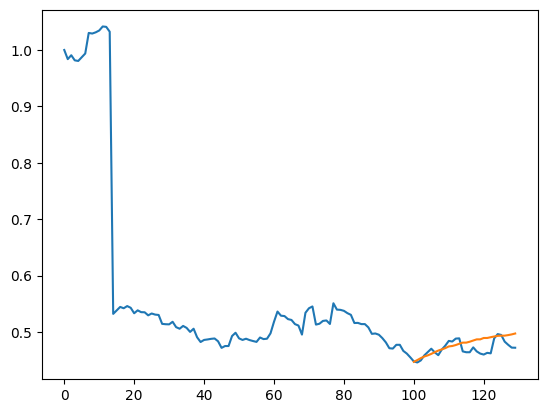

In [324]:
r=56
yy=torch.concatenate([X_test[r,:,0].cpu(),Y_test[r,:].cpu()])
xx=np.arange(days_history+days_predict)
plt.plot(xx,yy)
yyy=(model(torch.flatten(X_test[r,:,:]).unsqueeze(0)).detach()+ Y_test[r,0]).cpu() 
plt.plot(xx[days_history:days_history+days_predict] ,yyy.squeeze(0) )


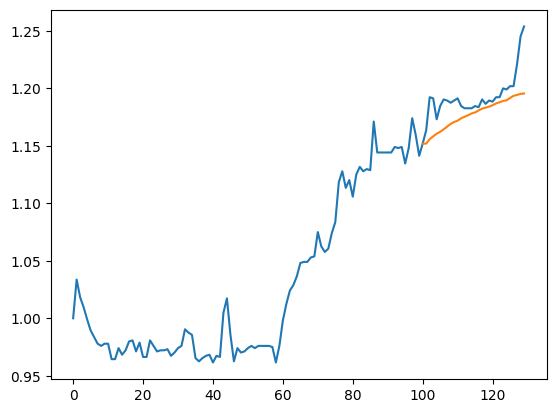

In [325]:
yy=torch.concatenate([X_train[r,:,0].cpu(),Y_train[r,:].cpu()])
xx=np.arange(days_history+days_predict)
plt.plot(xx,yy)
yyy=(model(torch.flatten(X_train[r,:,:]).unsqueeze(0)).detach()  + Y_train[r,0]).squeeze(0).cpu() 
plt.plot(xx[days_history:days_history+days_predict] , yyy )
